# 5th_homework

### Import Section

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

import lightfm
from lightfm.evaluation import precision_at_k

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Global Settings Section

In [2]:
random_state_global = 0

### Path Section

In [3]:
PATH_ROOT = r'../2th lesson/'

## Theoretical Part

#### 1. Ответьте на вопросы:
* В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?
* Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы

**Ответ:**

Коллаборативная фильтрация используется в случае, когда имеются обширные массивы данных, чтобы можно было определить категории схожих пользователей и категории схожих товаров. Применение гибридных рекомендательных систем имеет смысл тогда, тогда для решения задачи рекомендации возможно применение разных методов и их объединение позволяет повысить эффективность.

Так например гибридные рекомендательные системы могут быть использованы в следующих случаях:
1. Рекомендация методов лечения пациента, когда индивидуальные особенности организма не позволяют применить коллаборативную фильтрацию и нужен разносторонний подход.
2. Когда данные сильно отличаются друг от друга и необходима гибкость решения, как в судебной/юридической практике.
3. При недостатке больших данных, например, покупка дорогого имущества.

#### 2. Прочитайте статью про поиск на hh.ru
https://habr.com/ru/company/hh/blog/347276/

Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

**Ответ:**

Данная рекомендательная система является гибридной. Она состоит из нескольких моделей-фильтров и модели для финального ранжирования. При вводе такой системы в эксплуатацию могут возникнуть следующие проблемы:
- финальная ранжирующая модель является ресурсоёмкой. В случае, когда модели-фильтры допустят большой объём информации, могут возникнуть проблемы с производительностью;
- модели-фильтры также могут предоставить ранжирующей модели недостаточно данных или данные низкого качества, что приведёт к проблеме "Garbage in, garbage out".

#### 3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html).
В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:

1) Какой датасет используют авторы?

2) Что используют в качестве признаков?

3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко

**Ответ:**

1. Автор статьи использует данные из "модного" бизнеса. Ключевыми особенностями которых является сильная разреженность из-за большого количества новых продуктов и клиентов. В статье рассмотрен "холодный" старт в случае с разреженными и обильными данными.

2. В качестве признаков используются отличительные семантические особенности в описании продуктов.

3. В статье также фигурируют модель коллаборативной фильтрации, основанная на факторизации матрицы User-Item, и контентная модель, которая анализирует профиль (признаки) каждого продукта и конкретного пользователя и оценивает интерес последнего. Обе модели уступают LightFM.

## Practical Part

### 1. Модуль SRC

In [4]:
# !pip install "../4th lesson/4th_homework/dist/package_4th_homework-1.tar.gz"

In [5]:
from package_4th_homework import utils
from package_4th_homework import recommenders

In [6]:
recommenders.get_similar_items_recommendation
recommenders.get_similar_users_recommendation

<function package_4th_homework.recommenders.get_similar_users_recommendation(user, model_als, model_own, user_item_matrix, filter_items=[], N=5)>

В данном модуле находятся функции реализованные в прошлом задании. Utils содержит фукнции "prefilter_items" и "postfilter_items" для фильтрации. Recommenders содержит функции "get_similar_items_recommendation" и "get_similar_users_recommendation" для рекомендации на основе похожих продуктов и продуктов похожих пользователей соответственно.

### 2. Работа с признаками

In [7]:
# Загрузка данных.
data = pd.read_csv(PATH_ROOT + 'retail_train.csv')
item_features = pd.read_csv(PATH_ROOT + 'product.csv')
user_features = pd.read_csv(PATH_ROOT + 'hh_demographic.csv')

# Обработка названий столбцов.
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features = item_features.rename(columns={'product_id': 'item_id'})
user_features = user_features.rename(columns={'household_key': 'user_id'})

# Разбиение на обучающую и проверочную выборки.
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

#### item_features

In [8]:
# Вывод первых пяти строк признаков продуктов.
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [9]:
# Вывод основных статистик.
item_features.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_id,92353.0,NaN,NaN,NaN,5328352.836887,5359937.078029,25671.0,970628.0,1621091.0,9704770.0,18316298.0
manufacturer,92353.0,NaN,NaN,NaN,1739.22833,1818.26957,1.0,328.0,1094.0,2264.0,6477.0
department,92353,44,GROCERY,39021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,92353,2,National,78537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
commodity_desc,92353,308,GREETING CARDS/WRAP/PARTY SPLY,2785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_commodity_desc,92353,2383,CARDS EVERYDAY,1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
curr_size_of_product,92353,4345,,30607,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Вывод количества уникальных производителей.
item_features['manufacturer'].nunique()

6476

In [11]:
# Вывод распределения значений признака "department".
item_features['department'].value_counts(normalize=True).apply('{:.2%}'.format).head()

GROCERY      42.25%
DRUG GM      34.14%
PRODUCE       3.38%
COSMETICS     3.26%
NUTRITION     3.16%
Name: department, dtype: object

Text(0, 0.5, 'Количество товаров')

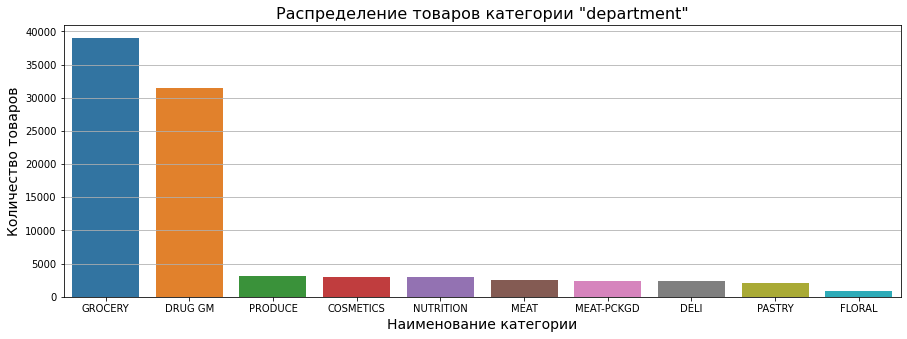

In [12]:
plt.figure(figsize=(15, 5))
plt.grid()

sns.barplot(x=item_features['department'].value_counts().reset_index().head(10)['index'],
            y=item_features['department'].value_counts().reset_index().head(10)['department'])

plt.title('Распределение товаров категории "department"', fontdict={'size': 16});
plt.xlabel('Наименование категории', fontdict={'size': 14})
plt.ylabel('Количество товаров', fontdict={'size': 14})

In [13]:
# Вывод распределения значений признака "brand".
item_features['brand'].value_counts(normalize=True).apply('{:.2%}'.format)

National    85.04%
Private     14.96%
Name: brand, dtype: object

Text(0, 0.5, 'Количество товаров')

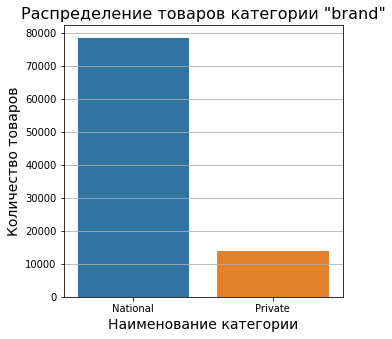

In [14]:
plt.figure(figsize=(5, 5))
plt.grid()

sns.barplot(x=item_features['brand'].value_counts().reset_index().head(10)['index'],
            y=item_features['brand'].value_counts().reset_index().head(10)['brand'])

plt.title('Распределение товаров категории "brand"', fontdict={'size': 16});
plt.xlabel('Наименование категории', fontdict={'size': 14})
plt.ylabel('Количество товаров', fontdict={'size': 14})

Согласно информации о товарах:
- представлены товары достаточно большого количества производителей, 6476 уникальных производителей. Дальнейший анализ производителей невозможен, так как никакой другой информации о них не представлено;
- большинство товаров из категорий "GROCERY" и "DRUG GM", ~42% и ~34% от всей выборки соответственно. Из-за достаточного количества товаров в данных категориях, поиск похожих товаров здесь будет наиболее эффективен;
- в большинстве случаев бренд товара "National".

#### user_features

In [15]:
# Вывод первых пяти строк признаков пользователей.
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [16]:
# Вывод основных статистик.
user_features.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age_desc,801,6,45-54,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status_code,801,3,U,344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income_desc,801,12,50-74K,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
homeowner_desc,801,5,Homeowner,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hh_comp_desc,801,6,2 Adults No Kids,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
household_size_desc,801,5,2,318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kid_category_desc,801,4,None/Unknown,558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,801.0,NaN,NaN,NaN,1235.17603,736.804647,1.0,596.0,1218.0,1914.0,2499.0


In [17]:
# Вывод распределения значений признака "age_desc".
user_features['age_desc'].value_counts(normalize=True).apply('{:.2%}'.format)

45-54    35.96%
35-44    24.22%
25-34    17.73%
65+       8.99%
55-64     7.37%
19-24     5.74%
Name: age_desc, dtype: object

Text(0, 0.5, 'Количество клиентов')

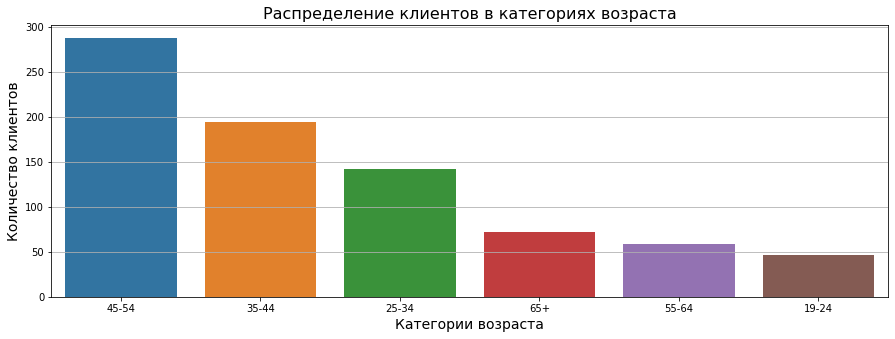

In [18]:
plt.figure(figsize=(15, 5))
plt.grid()

sns.barplot(x=user_features['age_desc'].value_counts().reset_index().head(10)['index'],
            y=user_features['age_desc'].value_counts().reset_index().head(10)['age_desc'])

plt.title('Распределение клиентов в категориях возраста', fontdict={'size': 16});
plt.xlabel('Категории возраста', fontdict={'size': 14})
plt.ylabel('Количество клиентов', fontdict={'size': 14})

In [19]:
# Вывод распределения значений признака "marital_status_code".
user_features['marital_status_code'].value_counts(normalize=True).apply('{:.2%}'.format)

U    42.95%
A    42.45%
B    14.61%
Name: marital_status_code, dtype: object

In [20]:
# Вывод распределения значений признака "income_desc".
user_features['income_desc'].value_counts(normalize=True).apply('{:.2%}'.format).head()

50-74K    23.97%
35-49K    21.47%
75-99K    11.99%
25-34K     9.61%
15-24K     9.24%
Name: income_desc, dtype: object

Text(0, 0.5, 'Количество клиентов')

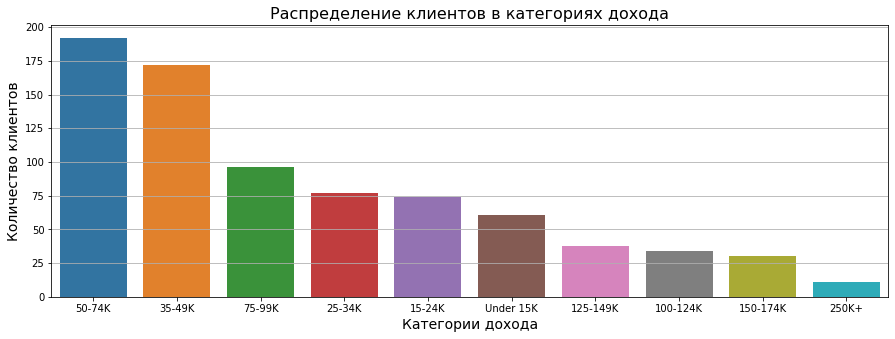

In [21]:
plt.figure(figsize=(15, 5))
plt.grid()

sns.barplot(x=user_features['income_desc'].value_counts().reset_index().head(10)['index'],
            y=user_features['income_desc'].value_counts().reset_index().head(10)['income_desc'])

plt.title('Распределение клиентов в категориях дохода', fontdict={'size': 16});
plt.xlabel('Категории дохода', fontdict={'size': 14})
plt.ylabel('Количество клиентов', fontdict={'size': 14})

In [22]:
# Вывод распределения значений признака "homeowner_desc".
user_features['homeowner_desc'].value_counts(normalize=True).apply('{:.2%}'.format).head()

Homeowner          62.92%
Unknown            29.09%
Renter              5.24%
Probable Renter     1.37%
Probable Owner      1.37%
Name: homeowner_desc, dtype: object

In [23]:
# Вывод распределения значений признака "hh_comp_desc".
user_features['hh_comp_desc'].value_counts(normalize=True).apply('{:.2%}'.format).head()

2 Adults No Kids    31.84%
2 Adults Kids       23.35%
Single Female       17.98%
Single Male         11.86%
Unknown              9.11%
Name: hh_comp_desc, dtype: object

In [24]:
# Вывод распределения значений признака "household_size_desc".
user_features['household_size_desc'].value_counts(normalize=True).apply('{:.2%}'.format).head()

2     39.70%
1     31.84%
3     13.61%
5+     8.24%
4      6.62%
Name: household_size_desc, dtype: object

In [25]:
# Вывод распределения значений признака "kid_category_desc".
user_features['kid_category_desc'].value_counts(normalize=True).apply('{:.2%}'.format)

None/Unknown    69.66%
1               14.23%
3+               8.61%
2                7.49%
Name: kid_category_desc, dtype: object

Анализ признаков клиентов позволил установить следующие закономерности:
- возрастные категории "45-54", "35-44" и "25-34" представляют основное большиснтво покупателей с долями ~36%, ~24%, ~18% соответственно. В первую очередь необходимо ориентироваться на эти возрастные категории;
- среди катеригой признака "marital_status_code" такжн присутствуют преобладание категорий "U" и "A" с практически равными долями ~43% и ~42% соответственно. Корректная интерпретация значений признака невозможна без сопроводительнорй документации;
- топ-3 дохода клиентов следующий: "50-74K", "35-49K", "75-99K" с долями ~24%, ~21%, ~12% соответственно.

#### Анализ категорий продуктов в истории покупок.

Проверим категории купленных товаров.

In [26]:
# Вывод категорий продуктов, которые были куплены.
(
data_train
    .merge(item_features[['item_id', 'department']], on='item_id')['department']
    .value_counts(normalize=True)
    .apply('{:.2%}'.format)
    .head()
)

GROCERY       63.33%
DRUG GM       10.67%
PRODUCE        9.98%
MEAT-PCKGD     4.33%
MEAT           3.42%
Name: department, dtype: object

In [27]:
# Вывод категорий продуктов, которые были куплены.
(
data_train
    .merge(item_features[['item_id', 'brand']], on='item_id')['brand']
    .value_counts(normalize=True)
    .apply('{:.2%}'.format)
)

National    71.28%
Private     28.72%
Name: brand, dtype: object

Наибольшие категории товаров из описания товаров также являются и наиболее покупаемыми.

#### Анализ категорий клиентов в истории покупок.

Проверим отражает ли распределние клиентов их реальное участие в покупке товаров.

In [28]:
# Вывод категорий возраста пользователей, которые совершали покупки.
(
data_train
    .merge(user_features[['user_id', 'age_desc']], on='user_id')['age_desc']
    .value_counts(normalize=True)
    .apply('{:.2%}'.format)
)

45-54    36.39%
35-44    27.09%
25-34    17.40%
65+       7.40%
55-64     6.40%
19-24     5.32%
Name: age_desc, dtype: object

In [29]:
# Вывод категорий дохода пользователей, которые совершали покупки.
(
data_train
    .merge(user_features[['user_id', 'income_desc']], on='user_id')['income_desc']
    .value_counts(normalize=True)
    .apply('{:.2%}'.format)
    .head()
)

50-74K       24.28%
35-49K       19.53%
75-99K       11.71%
25-34K        9.03%
Under 15K     8.12%
Name: income_desc, dtype: object

Распределение категорий возраста и дохода клиентов из описания клиентов также наблюдается в истории покупок. Самые большие категории совершают больше покупок, что значит, что на них необходимо ориентироваться в первую очередь для получения лучших прогнозов.

### 3. LightFM

#### Базовая модель из методички

In [30]:
# Подготовка обучающего набора данных.
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity = popularity.rename(columns={'quantity': 'n_sold'})
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0)

user_item_matrix = user_item_matrix.astype(float)

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
# Подготовка тестового набора данных.
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test,
                                       index='user_id',
                                       columns='item_id',
                                       values='quantity',
                                       aggfunc='count',
                                       fill_value=0)

# Добавление недостающих пользователей в тестовый набор данных.
test_user_item_matrix = pd.DataFrame(user_item_matrix.index).join(test_user_item_matrix, on='user_id', how='left').fillna(0)
test_user_item_matrix = test_user_item_matrix.set_index('user_id')

# Добавление недостающих товаров в тестовый набор данных.
items_absent = pd.DataFrame(index=test_user_item_matrix.index,
                            columns=[[item for item in user_item_matrix.columns if item not in test_user_item_matrix.columns]])
items_absent.loc[:, :] = 0
test_user_item_matrix = test_user_item_matrix.join(items_absent)

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [32]:
# Словари перевода user_id и item_id к порядковым id и наоброт.
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [33]:
# Подготовка матриц признаков пользователей и товаров.
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat = user_feat.set_index('user_id')

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat = item_feat.set_index('item_id')

user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [34]:
# Инициализация модели.
model = lightfm.LightFM(no_components=10,
                        loss='warp',
                        learning_rate=0.05,
                        item_alpha=0.1,
                        user_alpha=0.1,
                        random_state=random_state_global)

In [35]:
%%time

# Обучение модели.
model.fit((sparse_user_item > 0) * 1,
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15)

Wall time: 45.6 s


In [36]:
%%time

# Метрики.
df_metrics = pd.DataFrame(columns=['train', 'test'])

# Точность на обучающей выборке.
df_metrics.loc['baseline', 'train'] = precision_at_k(model,
                                                     sparse_user_item,
                                                     user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                     item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                     k=5).mean()

Wall time: 3.6 s


In [37]:
%%time

# Точность на тестовой выборке.
df_metrics.loc['baseline', 'test'] = precision_at_k(model,
                                                    sparse_user_item_test,
                                                    user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                    item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                    k=5).mean()

Wall time: 1.02 s


In [38]:
# Вывод метрик.
df_metrics

,train,test
baseline,0.533574,0.003242


Базовая модель демонстрирует переобучение: на обучающей выборке метрика гораздо выше, чем на тренировочной.

#### Обучение и валидация модели без признаков пользователей и товаров

In [39]:
# Инициализация модели.
model = lightfm.LightFM(no_components=10,
                        loss='warp',
                        learning_rate=0.05,
                        item_alpha=0.1,
                        user_alpha=0.1,
                        random_state=random_state_global)

In [40]:
%%time

# Обучение модели.
model.fit((sparse_user_item > 0) * 1,
          sample_weight=coo_matrix(user_item_matrix),
          epochs=15)

Wall time: 20.5 s


In [41]:
%%time

# Точность на обучающей выборке.
df_metrics.loc['without_features', 'train'] = precision_at_k(model,
                                                             sparse_user_item,
                                                             k=5).mean()

Wall time: 3.22 s


In [42]:
%%time

# Точность на тестовой выборке.
df_metrics.loc['without_features', 'test'] = precision_at_k(model,
                                                             sparse_user_item_test,
                                                             k=5).mean()

Wall time: 663 ms


In [43]:
# Вывод метрик.
df_metrics

,train,test
baseline,0.533574,0.003242
without_features,0.034814,0.009726


Обучение и валидация модели без признаков пользователей и товаров позволили снизить степерь переобучения.

#### Обучение и валидация настроенной модели без признаков пользователей и товаров

In [44]:
# Инициализация модели.
model = lightfm.LightFM(no_components=10,
                        loss='warp',
                        learning_rate=0.05,
                        item_alpha=0.09901,
                        user_alpha=0.099,
                        random_state=random_state_global)

In [45]:
%%time

# Обучение модели.
model.fit((sparse_user_item > 0) * 1,
          sample_weight=coo_matrix(user_item_matrix),
          epochs=15)

Wall time: 20.5 s


In [46]:
%%time

# Точность на обучающей выборке.
df_metrics.loc['without_features_settings', 'train'] = precision_at_k(model,
                                                       sparse_user_item,
                                                       k=5).mean()

Wall time: 3.22 s


In [47]:
%%time

# Точность на тестовой выборке.
df_metrics.loc['without_features_settings', 'test'] = precision_at_k(model,
                                                      sparse_user_item_test,
                                                      k=5).mean()

Wall time: 677 ms


In [48]:
# Вывод метрик.
df_metrics

,train,test
baseline,0.533574,0.003242
without_features,0.034814,0.009726
without_features_settings,0.046659,0.015603


Настройка гиперпараметров позволила улучшить метрику модели без признаков пользователей и товаров.

#### Обучение и валидация настроенной модели с признаками пользователей и товаров

In [49]:
# Инициализация модели.
model = lightfm.LightFM(no_components=8,
                        loss='warp',
                        learning_rate=0.05,
                        item_alpha=5,
                        user_alpha=5,
                        random_state=random_state_global)

In [50]:
%%time

# Обучение модели.
model.fit((sparse_user_item > 0) * 1,
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15)

Wall time: 24.1 s


In [51]:
%%time

# Точность на обучающей выборке.
df_metrics.loc['with_features_settings', 'train'] = precision_at_k(model,
                                                                   sparse_user_item,
                                                                   user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                                   item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                                   k=5).mean()

Wall time: 3.64 s


In [52]:
%%time

# Точность на тестовой выборке.
df_metrics.loc['with_features_settings', 'test'] = precision_at_k(model,
                                                                  sparse_user_item_test,
                                                                  user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                                  item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                                  k=5).mean()

Wall time: 960 ms


In [53]:
# Вывод метрик.
df_metrics

,train,test
baseline,0.533574,0.003242
without_features,0.034814,0.009726
without_features_settings,0.046659,0.015603
with_features_settings,0.12453,0.010841


Подбор гиперпараметров также улучшил метрику модели с признаками пользователей и товаров.

### 4. Отбор признаков

In [54]:
# Подготовка матриц признаков пользователей и товаров.
list_user_features = ['user_id', 'age_desc', 'income_desc']
list_item_features = ['item_id', 'department', 'brand']

# list_user_features = ['age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
#                       'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'user_id']
# list_item_features = ['item_id', 'manufacturer', 'department', 'brand', 'commodity_desc',
#                       'sub_commodity_desc', 'curr_size_of_product']

user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features[list_user_features], on='user_id', how='left')
user_feat = user_feat.set_index('user_id')

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features[list_item_features], on='item_id', how='left')
item_feat = item_feat.set_index('item_id')

user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [55]:
# Инициализация модели.
model = lightfm.LightFM(no_components=8,
                        loss='bpr',
                        learning_rate=0.25,
                        item_alpha=0.002, 
                        user_alpha=0.002,
                        random_state=random_state_global)

In [56]:
%%time

# Обучение модели.
model.fit((sparse_user_item > 0) * 1,
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15)

Wall time: 18 s


In [57]:
%%time

# Точность на обучающей выборке.
df_metrics.loc['feature_engineering', 'train'] = precision_at_k(model,
                                                                sparse_user_item,
                                                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                                k=5).mean()

Wall time: 2.92 s


In [58]:
%%time

# Точность на тестовой выборке.
df_metrics.loc['feature_engineering', 'test'] = precision_at_k(model,
                                                               sparse_user_item_test,
                                                               user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                               item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                               k=5).mean()

Wall time: 638 ms


In [59]:
# Вывод метрик.
df_metrics

,train,test
baseline,0.533574,0.003242
without_features,0.034814,0.009726
without_features_settings,0.046659,0.015603
with_features_settings,0.12453,0.010841
feature_engineering,0.202001,0.002432


Замена и исключение признаков не принесли результата.